# Variational Autoencoder

In [1]:
import logging

import pandas as pd
from IPython.display import display

import pimmslearn
import pimmslearn.model
import pimmslearn.models as models
import pimmslearn.nb
from pimmslearn.io import datasplits

logger = pimmslearn.logging.setup_logger(logging.getLogger('pimmslearn'))
logger.info("Median Imputation")

figures = {}  # collection of ax or figures

pimmslearn - INFO     Median Imputation


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
folder_experiment: str = 'runs/example'  # Datasplit folder with data for experiment
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'  # Metadata for samples
# model
sample_idx_position: int = 0  # position of index which is sample ID
model_key: str = 'Median'  # model key (lower cased version will be used for file names)
model: str = 'Median'  # model name
save_pred_real_na: bool = True  # Save all predictions for real na
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "Median"
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"
model_key = "Median"


Some argument transformations

In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/alzheimer_study',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'sample_idx_position': 0,
 'model_key': 'Median',
 'model': 'Median',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = pimmslearn.nb.args_from_dict(args)
args

{'data': Path('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_experiment': Path('runs/alzheimer_study'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID   protein groups                                     
Sample_013  Q02809;Q02809-2                                       15.195
Sample_113  Q16620;Q16620-2;Q16620-3;Q16620-4;Q16620-5;Q16620-6   17.484
Sample_052  Q8NCC3                                                15.976
Sample_110  F8W785;O00461                                         14.359
Sample_083  P00747                                                20.623
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError("More than one feature: Needs to be implemented. see above logging output.")

pimmslearn - INFO     sample_id = 'Sample ID', single feature: index_column = 'protein groups'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,_collection site,_age at CSF collection,_gender,_t-tau [ng/L],_p-tau [ng/L],_Abeta-42 [ng/L],_Abeta-40 [ng/L],_Abeta-42/Abeta-40 ratio,_primary biochemical AD classification,_clinical AD diagnosis,_MMSE score
Sample ID,,,,,,,,,,,
Sample_000,Sweden,71.000,f,703.000,85.000,562.000,NaN,NaN,biochemical control,NaN,NaN
Sample_001,Sweden,77.000,m,518.000,91.000,334.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_002,Sweden,75.000,m,974.000,87.000,515.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_003,Sweden,72.000,f,950.000,109.000,394.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_004,Sweden,63.000,f,873.000,88.000,234.000,NaN,NaN,biochemical AD,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,Berlin,69.000,f,"1,945.000",NaN,699.000,"12,140.000",0.058,biochemical AD,AD,17.000
Sample_206,Berlin,73.000,m,299.000,NaN,"1,420.000","16,571.000",0.086,biochemical control,non-AD,28.000
Sample_207,Berlin,71.000,f,262.000,NaN,639.000,"9,663.000",0.066,biochemical control,non-AD,28.000


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = pimmslearn.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

protein groups
A0A024QZX5;A0A087X1N8;P35237                                                     197
A0A024R0T9;K7ER74;P02655                                                         208
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   185
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          208
A0A075B6H7                                                                        97
Name: freq, dtype: int64

### Produce some addional fake samples

The validation fake NA is used to by all models to evaluate training performance.

In [13]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [14]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN


### Add interpolation performance

In [16]:
# interpolated = pimmslearn.pandas.interpolate(wide_df = data.train_X)
# val_pred_fake_na['interpolated'] = interpolated
# test_pred_fake_na['interpolated'] = interpolated
# del interpolated
# test_pred_fake_na

In [17]:
# Add median pred performance
args.n_params = data.train_X.shape[-1]
medians_train = data.train_X.median()
medians_train.name = args.model
pred = medians_train

val_pred_fake_na = val_pred_fake_na.join(medians_train)
test_pred_fake_na = test_pred_fake_na.join(medians_train)
val_pred_fake_na

,,observed,Median
Sample ID,protein groups,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.752
Sample_050,Q9Y287,15.755,17.221
Sample_107,Q8N475;Q8N475-2,15.029,14.846
Sample_199,P06307,19.376,18.973
Sample_067,Q5VUB5,15.309,14.726
...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.918
Sample_002,A0A0A0MT36,18.165,15.877
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,16.278


In [18]:
if args.save_pred_real_na:
    mask = data.train_X.isna().stack()
    idx_real_na = mask.index[mask]
    idx_real_na = (idx_real_na
                   .drop(val_pred_fake_na.index)
                   .drop(test_pred_fake_na.index))
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(medians_train)
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Median
Sample ID  protein groups                  
Sample_000 A0A075B6J9                16.691
           A0A075B6Q5                16.503
           A0A075B6R2                17.090
           A0A075B6S5                16.203
           A0A087WSY4                15.732
...                                     ...
Sample_209 Q9P1W8;Q9P1W8-2;Q9P1W8-4  16.019
           Q9UI40;Q9UI40-2           16.744
           Q9UIW2                    15.057
           Q9UMX0;Q9UMX0-2;Q9UMX0-4  13.739
           Q9UP79                    15.525

[46401 rows x 1 columns]

### Plots


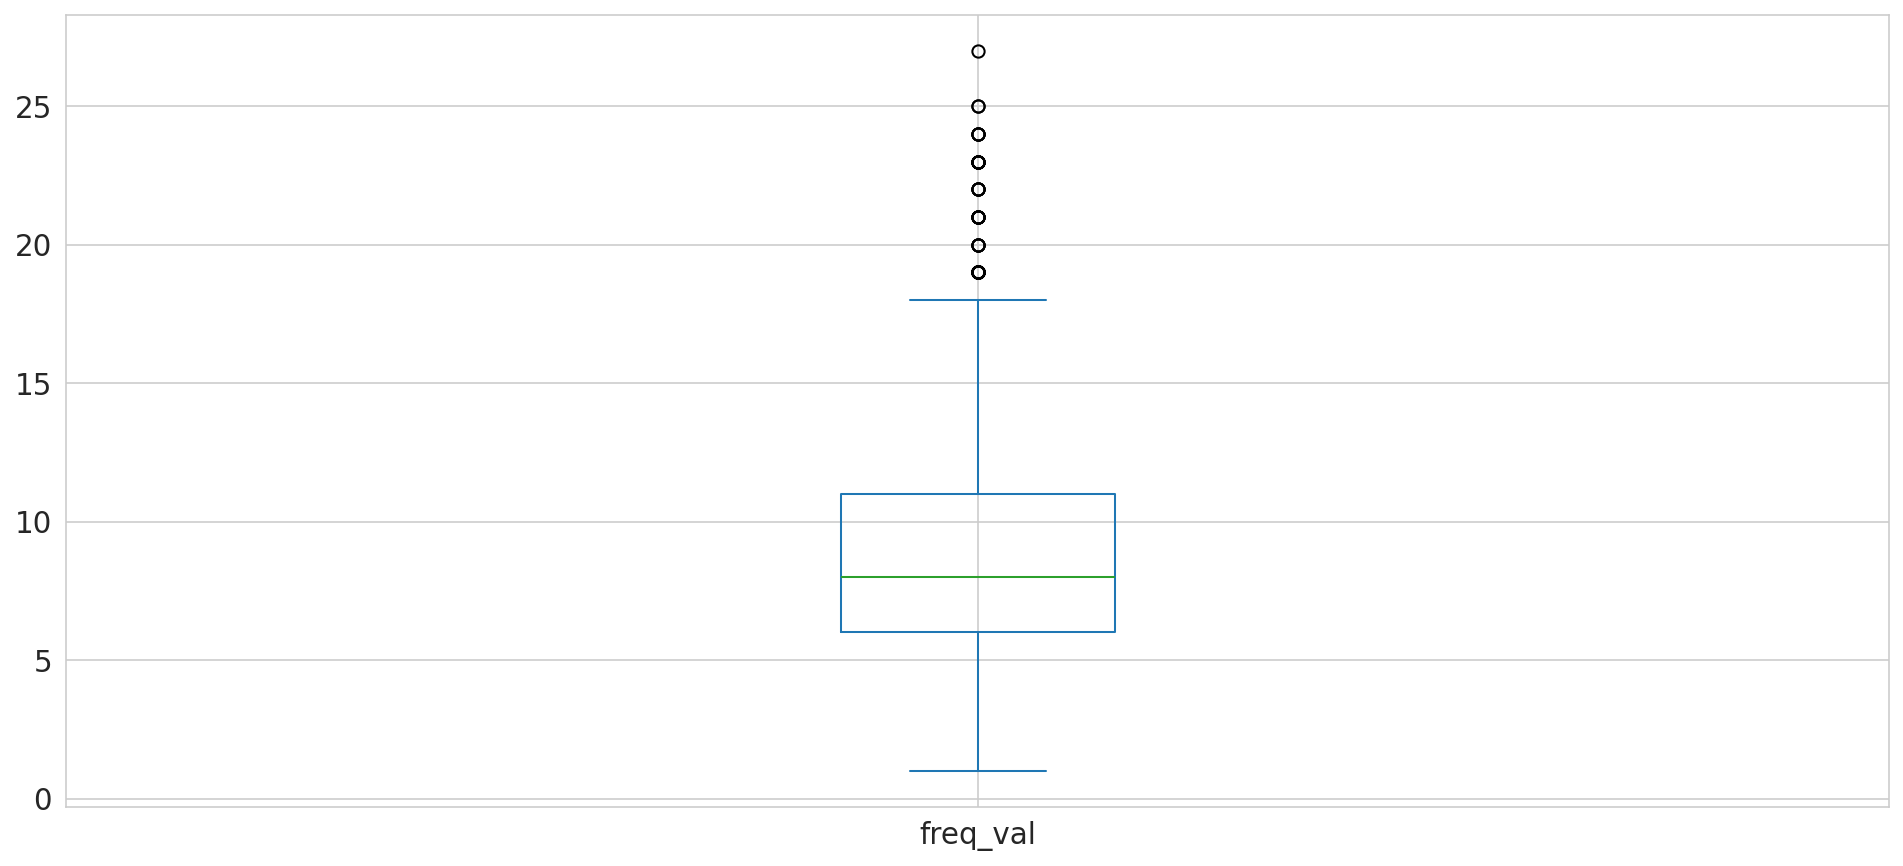

In [19]:
feat_freq_val = val_pred_fake_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [20]:
# # scatter plot between overall feature freq and split freq
# freq_feat.to_frame('overall').join(feat_freq_val).plot.scatter(x='overall', y='freq_val')

In [21]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

freq_val
1    12
2    18
3    50
4    82
5   108
Name: count, dtype: int64

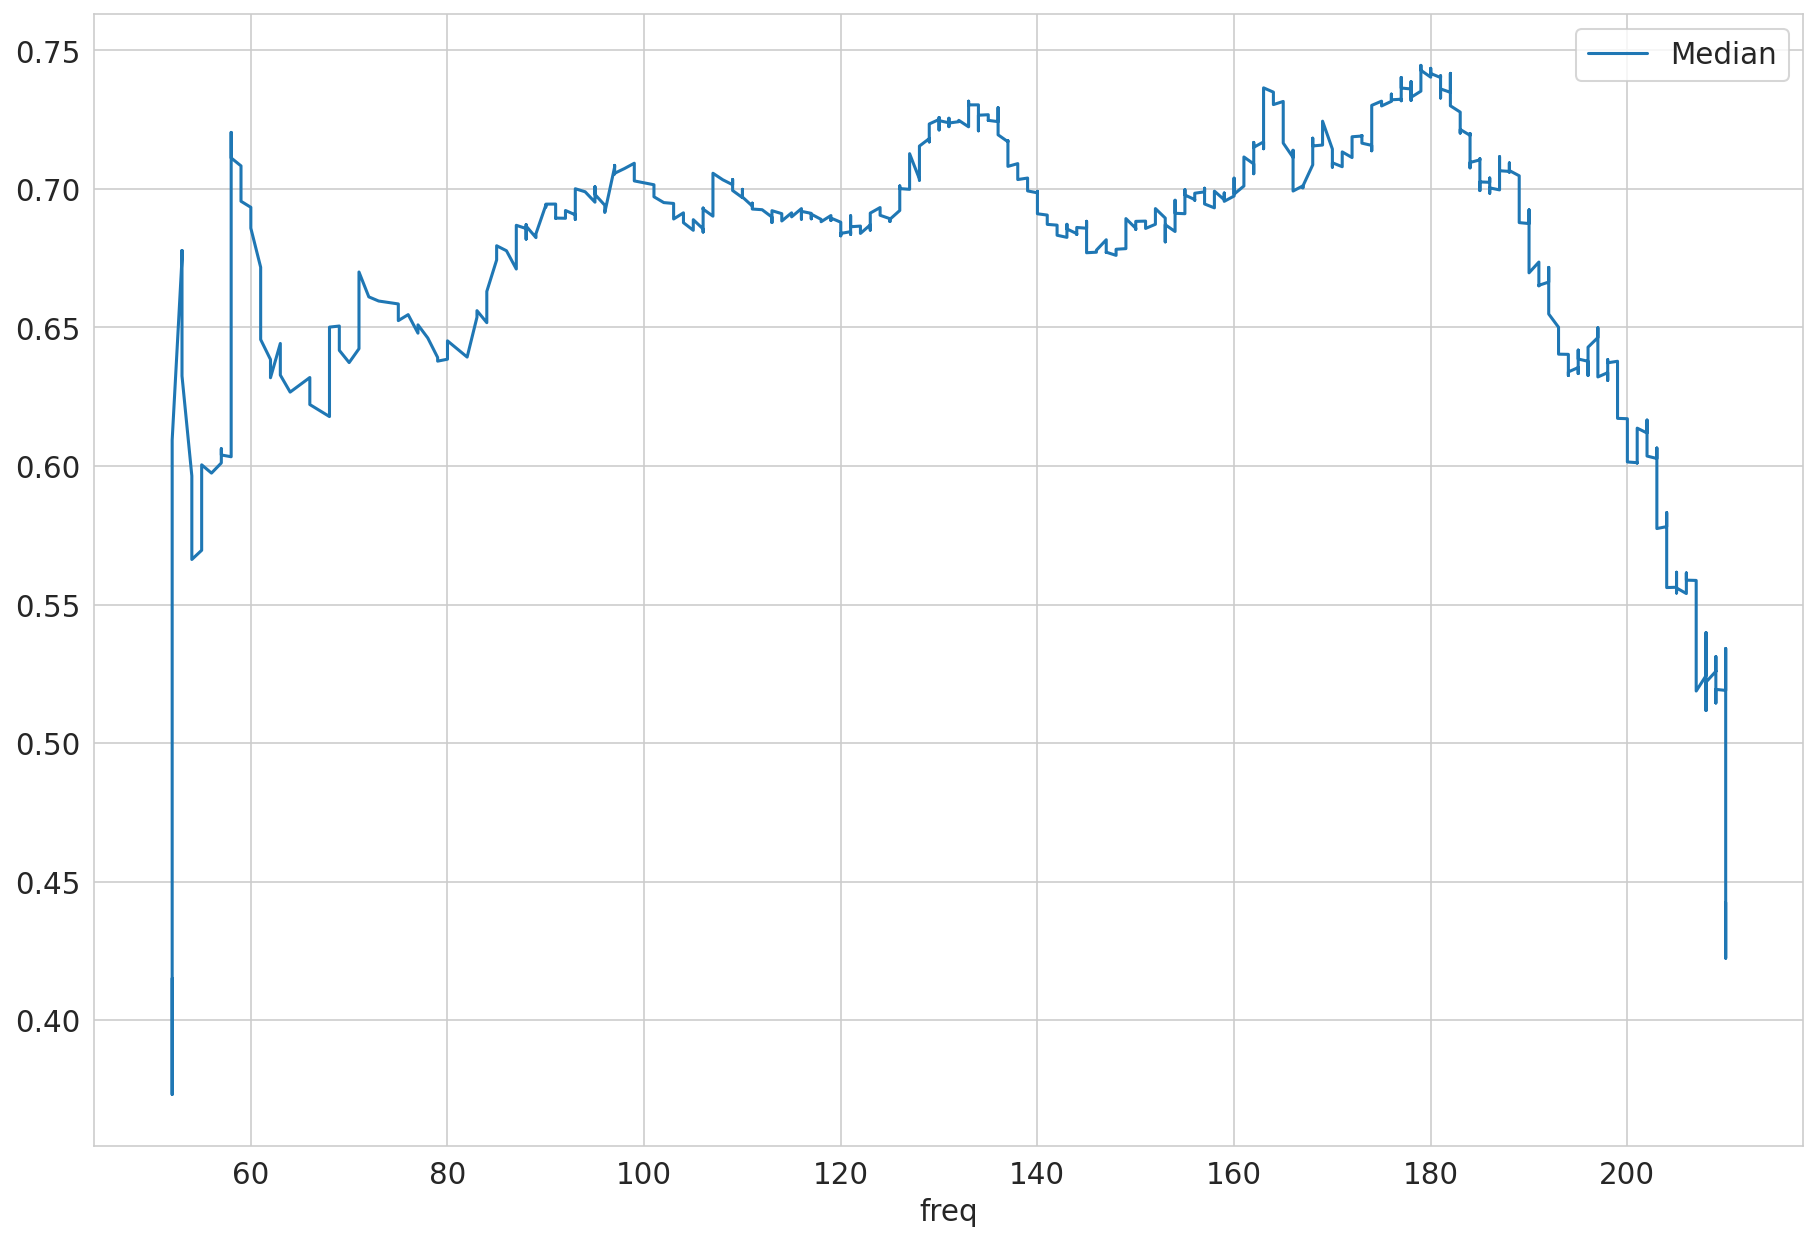

In [22]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-
                                       1]] = errors_val[errors_val.columns[:-
                                                                           1]].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [23]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

Median  \
                                                                                 mean   
protein groups                                                                          
A0A024QZX5;A0A087X1N8;P35237                                                    0.270   
A0A024R0T9;K7ER74;P02655                                                        1.713   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8  0.361   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                         0.451   
A0A075B6H7                                                                      0.773   
...                                                                               ...   
Q9Y6R7                                                                          0.489   
Q9Y6X5                                                                          0.538   
Q9Y6Y8;Q9Y6Y8-2                                                                 0.454   
Q9Y6Y9                                                                          0.812   
S4R3U6                                                                          0.518   

                                                                                      
                                                                               count  
protein groups                                                                        
A0A024QZX5;A0A087X1N8;P35237                                                       7  
A0A024R0T9;K7ER74;P02655                                                           4  
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8     9  
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                            6  
A0A075B6H7                                                                         6  
...                                                                              ...  
Q9Y6R7                                                                            10  
Q9Y6X5                                                                             7  
Q9Y6Y8;Q9Y6Y8-2                                                                    9  
Q9Y6Y9                                                                            15  
S4R3U6                                                                            24  

[1419 rows x 2 columns]

In [24]:
errors_val

,,Median
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,1.122
Sample_050,Q9Y287,1.466
Sample_107,Q8N475;Q8N475-2,-0.183
Sample_199,P06307,-0.403
Sample_067,Q5VUB5,-0.583
...,...,...
Sample_111,F6SYF8;Q9UBP4,0.096
Sample_002,A0A0A0MT36,-2.288
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,0.753


## Comparisons

### Validation data


In [25]:
# papermill_description=metrics
d_metrics = models.Metrics()

The fake NA for the validation step are real test data (not used for training nor early stopping)

In [26]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na, 'valid_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 0.766059536868567,
  'MAE': 0.5984580373149887,
  'N': 12600,
  'prop': 1.0}}

### Test Datasplit

Fake NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [27]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na, 'test_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 0.7764184180515228,
  'MAE': 0.6020439727512931,
  'N': 12600,
  'prop': 1.0}}

The fake NA for the validation step are real test data (not used for training nor early stopping)

### Save all metrics as json

In [28]:
pimmslearn.io.dump_json(d_metrics.metrics, args.out_metrics / f'metrics_{args.model_key}.json')
d_metrics

{ 'test_fake_na': { 'Median': { 'MAE': 0.6020439727512931,
                                'MSE': 0.7764184180515228,
                                'N': 12600,
                                'prop': 1.0}},
  'valid_fake_na': { 'Median': { 'MAE': 0.5984580373149887,
                                 'MSE': 0.766059536868567,
                                 'N': 12600,
                                 'prop': 1.0}}}

In [29]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset              valid_fake_na  test_fake_na
model  metric_name                             
Median MSE                  0.766         0.776
       MAE                  0.598         0.602
       N               12,600.000    12,600.000
       prop                 1.000         1.000

## Save predictions

In [30]:
# val
fname = args.out_preds / f"pred_val_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())  # add [] assignment?
val_pred_fake_na.to_csv(fname)
# test
fname = args.out_preds / f"pred_test_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())
test_pred_fake_na.to_csv(fname)

## Config

In [31]:
figures  # switch to fnames?

{}

In [32]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 1421,
 'data': Path('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_experiment': Path('runs/alzheimer_study'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'n_params': 1421,
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'pred_test_Median': 'runs/alzheimer_study/preds/pred_test_Median.csv',
 'pred_val_Median': 'runs/alzheimer_study/preds/pred_val_Median.csv',
 'sample_idx_position': 0,
 'save_pred_real_na': True}